In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from copy import deepcopy

### Global Variables

In [141]:
epochs = 100
r_epochs = 2000 # num epochs for regularization
folds = 12
a = 0.25 # alpha for regularization
n_features = 87 # number of selected features after regularization
degree = 2 # polynomial degree

# local setup
dataset_path = '../../Datasets/Kaggle/Credit_Score'
output_path = dataset_path

# kaggle kernel setup
# dataset_path = '/kaggle/input/uwindsor-ai-club-can-credit-score-be-predicted'
# output_path = '/kaggle/working'

In [142]:
def plot_data(x, y):
    plt.plot(x, y)
    plt.show()

In [143]:
def load_data(data):
    df = pd.read_csv(data)
    return df

### Load Train and Test Data

kaggle link of the data : <br>
https://www.kaggle.com/competitions/uwindsor-ai-club-can-credit-score-be-predicted/data <br>
then download the <span style = "color : red">train.csv, test.csv and sample_submission.csv </span>

In [144]:
# read train and test data

train_data = load_data(f'{dataset_path}/train.csv')
test_data = load_data(f'{dataset_path}/test.csv')

# sample_submission = load_data(f'{dataset_path}/sample_submission.csv')

### Check Null values in Train and Test Data

In [145]:
train_data.isnull().sum()

# train_data = train_data.sample(frac = 1, random_state = 2)

CUST_ID                0
INCOME                 0
SAVINGS                0
DEBT                   0
R_SAVINGS_INCOME       0
                      ..
CAT_MORTGAGE           0
CAT_SAVINGS_ACCOUNT    0
CAT_DEPENDENTS         0
CREDIT_SCORE           0
DEFAULT                0
Length: 87, dtype: int64

In [146]:
# prints out the columns and the num of null values if any null value is found
print(f'\nTrain')
for i, val in enumerate(train_data.isnull().sum()):
    if(val > 0):
        print(f'col : {train_data.columns[i]}, val : {val}')
print(f'\nTest')
for i, val in enumerate(test_data.isnull().sum()):
    if(val > 0):
        print(f'col : {test_data.columns[i]}, val : {val}')


Train

Test


### Train and Test Splits

- Keeping the train_data for train and val
- Keeping the test_data for X_test only (y_test = CREDIT_SCORE column is not given, it should be predicted by us)
- Dropping **CUST_ID** from X_train and X_test 
- train_data -> X_train, y_train (90% of the train.csv) (After feature selection)
- test_data -> X_test (10% of the train.csv) (After feature selection) (y_test is not given)
- Check the shapes to verify correct formatting

In [147]:
# dividing the data into two parts : predictors, targets
X_train = train_data.drop(columns = ['CUST_ID', 'CREDIT_SCORE'], axis = 1)
y_train = train_data['CREDIT_SCORE']

X_test = test_data.drop('CUST_ID', axis = 1)

print(f'X_train.shape : {X_train.shape}')
print(f'y_train.shape : {y_train.shape}')
print(f'X_test.shape : {X_test.shape}')

X_train.shape : (700, 85)
y_train.shape : (700,)
X_test.shape : (300, 85)


In [148]:
# all the cols in the X_train
train_cols = X_train.columns
print(f'type(train_cols) : {type(train_cols)}')
print(f'Number of train_cols : {len(train_cols)}')
print(f'--------------------------------------------')
print(f'--------------------------------------------')

type(train_cols) : <class 'pandas.core.indexes.base.Index'>
Number of train_cols : 85
--------------------------------------------
--------------------------------------------


### Inspect Data before Preprocessing

In [149]:
# sns.heatmap(train_data.isnull(), cmap = 'viridis')

In [150]:
# for col_name, col_type in train_data.dtypes.items():
#     print(f'{col_name} -> {col_type}')

In [151]:
train_data['CAT_GAMBLING'].value_counts()

CAT_GAMBLING
No      439
High    182
Low      79
Name: count, dtype: int64

# Preprocessing

<br>

- From this part we will be working **Only** with **X_train, X_test** (instead of train_data, test_data)
- We have **CREDIT_SCORE** already separated
- X_train and X_test do not have **CUST_ID** (Not a feature, so dropped it while forming X_train, X_test) 
- Convert the categorical col **CAT_GAMBLING** into 2 numerical dummy cols
- Find columns which are highly correlated to one another and drop any one of them (pruning)
- **CUST_ID** will be joined with y_pred after prediction 

In [152]:
X_test['CAT_GAMBLING'].value_counts()

CAT_GAMBLING
No      181
High     82
Low      37
Name: count, dtype: int64

In [153]:
from itertools import combinations

dummy_cols = pd.get_dummies(X_train['CAT_GAMBLING'], dtype = int, drop_first = True)
dummy_cols_test = pd.get_dummies(X_test['CAT_GAMBLING'], dtype = int, drop_first = True)

X_train = pd.concat([X_train.drop(columns = ['CAT_GAMBLING']), dummy_cols], axis = 1)
X_test = pd.concat([X_test.drop(columns = ['CAT_GAMBLING']), dummy_cols_test], axis = 1)

columns_to_drop = []

for c1, c2 in combinations(X_train.columns, 2):
    if np.abs(X_train[c1].corr(X_train[c2])) >= 0.88:
#         print(f'c1 : {c1}, c2 : {c2}, corr = {X_train[c1].corr(X_train[c2])}')
        columns_to_drop.append(c2)

X_train.drop(columns = columns_to_drop, inplace = True, axis = 1)
X_test.drop(columns = columns_to_drop, inplace = True, axis = 1)

# Initial cols = 87
# Removed CUST_ID, CREDIT_SCORE -> 85
# Replaced CAT_GAMLING with 2 int cols -> 86
print(f'X_train.cols : {len(X_train.columns)}')
print(f'X_test.cols : {len(X_test.columns)}')

# test whether the current data is in the correct shape
print(f'\nX_train : {X_train.shape}, y_train : {y_train.shape}')
print(f'X_train tail columns : {X_train.columns[-1:-5:-1]}')
print(f'\nX_test : {X_test.shape}')
print(f'X_test tail columns : {X_test.columns[-1:-5:-1]}')

X_train.cols : 67
X_test.cols : 67

X_train : (700, 67), y_train : (700,)
X_train tail columns : Index(['No', 'Low', 'DEFAULT', 'CAT_DEPENDENTS'], dtype='object')

X_test : (300, 67)
X_test tail columns : Index(['No', 'Low', 'DEFAULT', 'CAT_DEPENDENTS'], dtype='object')


### Inspect after Preprocessing

In [154]:
# check the correlations of each feature target column pair

# data = pd.concat([X_train, y_train], axis=1)

# # Calculate the correlation matrix
# correlation_matrix = data.corr()

# # Define the threshold for low correlation
# threshold = 0.2  # Adjust as needed

# # Filter features with correlation below the threshold
# low_corr_features = correlation_matrix[correlation_matrix['CREDIT_SCORE'].abs() < threshold].index

# # Filter the correlation matrix to include only low correlation features
# low_corr_matrix = correlation_matrix.loc[low_corr_features, low_corr_features]

# # Plot the correlation matrix of low correlation features as a heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(low_corr_matrix, annot = False, cmap='coolwarm')

## Feature Engineering

In [155]:
# corr_threshold = 0.05

# cols = []
# # select features that are highly correlated with target 
# for col in X_train.columns:
#     cr = X_train[col].corr(y_train)
#     if(np.abs(cr) >= corr_threshold):
#         cols.append(col)
#         print(f'col : {col}, cr : {cr}')
# print(f'total columns to include : {len(cols)}')

# # include only the highly correlated cols in X_train and X_test
# X_train = X_train[cols]
# X_test = X_test[cols]

# sns.pairplot(X_train)
# print(f'X_train : {X_train.head()}')
# print(f'X_test : {X_test.head()}')

### Scale and Normalize

In [156]:
# # normalize data
# from mlxtend.preprocessing import minmax_scaling
# from scipy import stats

# # at first select the columns to apply the scaling and normalizing (except the binary cols)
# bin_cols = X_train.columns[(X_train.eq(0) | X_train.eq(1)).all()]
# non_bin_cols = X_train.columns.difference(bin_cols)

# X_train, X_test = pd.concat([minmax_scaling(X_train, columns = non_bin_cols), X_train[bin_cols]], axis = 1), pd.concat([minmax_scaling(X_test, columns = non_bin_cols), X_test[bin_cols]], axis = 1)

# # X_train[cols[2]], = stats.boxcox(X_train[cols[2]] + 0.5)

# epsilon = 1e-10
# for col in X_train.columns:
#     if(col in non_bin_cols):
#         X_train[col], _ = stats.boxcox(X_train[col] + epsilon)
#         X_test[col], _ = stats.boxcox(X_test[col] + epsilon)

# sns.pairplot(X_train)

In [157]:
# # replace the zero values of the features with mean value
# for col in X_train.columns:
#     if(col != 'DEBT'):
#         X_train[col].replace(0, 1, inplace = True)
#         X_test[col].replace(0, 1, inplace = True)
        

# # inspect distributions of the features
# X_train = pd.concat([np.log(X_train.iloc[:,:-1]), X_train.iloc[:,-1]], axis = 1)
# X_test = pd.concat([np.log(X_test.iloc[:,:-1]), X_test.iloc[:,-1]], axis = 1)

# sns.pairplot(X_train)

### ...........................................................
# Baselines
### ...........................................................

### LinearRegression

In [158]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

lr = LinearRegression()
nmse = cross_val_score(lr, X_train, y_train, scoring = 'neg_mean_squared_error', cv = folds)
mean_rmse = np.mean(np.sqrt(-nmse))

print(f'LR mean rmse = {mean_rmse}')

LR mean rmse = 28.239422809192064


### Ridge Regression

In [159]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

ridge = Ridge()
params = {'ridge__alpha' : [1e-2, 1, 5, 10, 20, 30, 35, 40, 45, 50, 100], \
          'ridge__max_iter' : [100, 500, 1000, 2500]}
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', ridge)
])
rr = GridSearchCV(pipeline, params, scoring = 'neg_mean_squared_error', cv = folds)
rr.fit(X_train, y_train)

# best params
a = rr.best_params_
nmse = rr.best_score_
rmse = np.sqrt(-nmse)

print(f'RR best alpha = {a}')
print(f'RR rmse = {rmse}')

RR best alpha = {'ridge__alpha': 20, 'ridge__max_iter': 100}
RR rmse = 28.165729554688834


### Lasso Regression

In [160]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

lasso_regressor = Lasso()
params = {'lasso__alpha' : [1e-7, 1e-5, 1e-2, 1, 5, 10, 20, 30, 35, 40], \
          'lasso__max_iter' : [500, 1000, 2500], \
         'lasso__tol' : [0.01, 0.02, 0.03, 0.05, 0.0005]}
#          'lasso__tol' : [0.05]}
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', lasso_regressor)
])
lasso_regressor = GridSearchCV(pipeline, params, scoring = 'neg_mean_squared_error', cv = folds)
lasso_regressor.fit(X_train, y_train)

# best params
a = lasso_regressor.best_params_
nmse = lasso_regressor.best_score_
rmse = np.sqrt(-nmse)

print(f'lasso_regressor best alpha = {a}')
print(f'lasso_regressor rmse = {rmse}')

C:\Users\Jamil88\.conda\envs\nlp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.152e+05, tolerance: 2.575e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\Jamil88\.conda\envs\nlp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.086e+05, tolerance: 2.513e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\Jamil88\.conda\envs\nlp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality 

C:\Users\Jamil88\.conda\envs\nlp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.086e+05, tolerance: 7.538e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\Jamil88\.conda\envs\nlp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.054e+05, tolerance: 7.973e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\Jamil88\.conda\envs\nlp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality 

C:\Users\Jamil88\.conda\envs\nlp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.054e+05, tolerance: 1.329e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\Jamil88\.conda\envs\nlp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.056e+05, tolerance: 1.336e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\Jamil88\.conda\envs\nlp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality 

C:\Users\Jamil88\.conda\envs\nlp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.032e+05, tolerance: 5.152e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\Jamil88\.conda\envs\nlp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.026e+05, tolerance: 5.255e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\Jamil88\.conda\envs\nlp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality 

C:\Users\Jamil88\.conda\envs\nlp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.056e+05, tolerance: 1.336e+05
  model = cd_fast.enet_coordinate_descent(
C:\Users\Jamil88\.conda\envs\nlp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.032e+05, tolerance: 1.288e+05
  model = cd_fast.enet_coordinate_descent(
C:\Users\Jamil88\.conda\envs\nlp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality 

C:\Users\Jamil88\.conda\envs\nlp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.053e+05, tolerance: 2.658e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\Jamil88\.conda\envs\nlp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.439e+05, tolerance: 2.673e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\Jamil88\.conda\envs\nlp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality 

C:\Users\Jamil88\.conda\envs\nlp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.053e+05, tolerance: 7.973e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\Jamil88\.conda\envs\nlp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.439e+05, tolerance: 8.018e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\Jamil88\.conda\envs\nlp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality 

C:\Users\Jamil88\.conda\envs\nlp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.601e+05, tolerance: 1.288e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\Jamil88\.conda\envs\nlp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.846e+04, tolerance: 1.314e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\Jamil88\.conda\envs\nlp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality 

C:\Users\Jamil88\.conda\envs\nlp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.080e+05, tolerance: 5.223e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\Jamil88\.conda\envs\nlp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.037e+05, tolerance: 5.201e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\Jamil88\.conda\envs\nlp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality 

C:\Users\Jamil88\.conda\envs\nlp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.037e+05, tolerance: 1.300e+05
  model = cd_fast.enet_coordinate_descent(
C:\Users\Jamil88\.conda\envs\nlp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.964e+05, tolerance: 1.357e+05
  model = cd_fast.enet_coordinate_descent(
C:\Users\Jamil88\.conda\envs\nlp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality 

C:\Users\Jamil88\.conda\envs\nlp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.713e+05, tolerance: 2.714e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\Jamil88\.conda\envs\nlp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.011e+05, tolerance: 2.695e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\Jamil88\.conda\envs\nlp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality 

C:\Users\Jamil88\.conda\envs\nlp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.011e+05, tolerance: 8.084e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\Jamil88\.conda\envs\nlp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.971e+05, tolerance: 7.749e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\Jamil88\.conda\envs\nlp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality 

C:\Users\Jamil88\.conda\envs\nlp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.011e+05, tolerance: 1.347e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\Jamil88\.conda\envs\nlp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.971e+05, tolerance: 1.292e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\Jamil88\.conda\envs\nlp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality 

lasso_regressor best alpha = {'lasso__alpha': 1, 'lasso__max_iter': 500, 'lasso__tol': 0.01}
lasso_regressor rmse = 27.531706402729764


### XGBoost


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Create an XGBoost regressor model
xgb = XGBRegressor()

# Best parameters: {'n_estimators': 250, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.05, 'lambda': 20, 'booster': 'gbtree'}

# pass 2
param_dist = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [2, 3, 5, 10],
    'booster' : ['gbtree'],
    'min_child_weight': [1, 2, 3, 4, 5],
    'lambda' : [0.1, 0.5, 1, 5, 10, 20, 30],
    'n_estimators': [50, 100, 250, 500, 1000, 1500]
}

# Perform randomized search with cross-validation
random_search = RandomizedSearchCV(xgb, param_distributions=param_dist, n_iter=100, scoring='neg_mean_squared_error', cv=folds)
random_search.fit(X_train, y_train)

# Get the best parameters and RMSE score
best_params = random_search.best_params_
best_rmse = np.sqrt(-random_search.best_score_)

print("Best parameters:", best_params)
print("Best RMSE:", best_rmse)


### Experimental Model Section

To test the model drafts here (The data preprocessing should be done beforehand)

In [88]:
X_train_bk, y_train_bk, X_test_bk = X_train, y_train, X_test

................... Fold : 1 ...............



  0%|          | 0/100 [00:00<?, ?it/s]


val_loss at fold 1 : 35.87628788247974
-------------------------------------

................... Fold : 2 ...............



  0%|          | 0/100 [00:00<?, ?it/s]


val_loss at fold 2 : 47.970012198377646
-------------------------------------

................... Fold : 3 ...............



  0%|          | 0/100 [00:00<?, ?it/s]


val_loss at fold 3 : 37.84707226333696
-------------------------------------

................... Fold : 4 ...............



  0%|          | 0/100 [00:00<?, ?it/s]


val_loss at fold 4 : 46.80984012803825
-------------------------------------

................... Fold : 5 ...............



  0%|          | 0/100 [00:00<?, ?it/s]


val_loss at fold 5 : 42.90689297588151
-------------------------------------

................... Fold : 6 ...............



  0%|          | 0/100 [00:00<?, ?it/s]


val_loss at fold 6 : 47.88314582707443
-------------------------------------

................... Fold : 7 ...............



  0%|          | 0/100 [00:00<?, ?it/s]


val_loss at fold 7 : 40.96834924241441
-------------------------------------

................... Fold : 8 ...............



  0%|          | 0/100 [00:00<?, ?it/s]


val_loss at fold 8 : 50.58455174260221
-------------------------------------

................... Fold : 9 ...............



  0%|          | 0/100 [00:00<?, ?it/s]


val_loss at fold 9 : 49.229691244207494
-------------------------------------

................... Fold : 10 ...............



  0%|          | 0/100 [00:00<?, ?it/s]


val_loss at fold 10 : 43.21770775587103
-------------------------------------



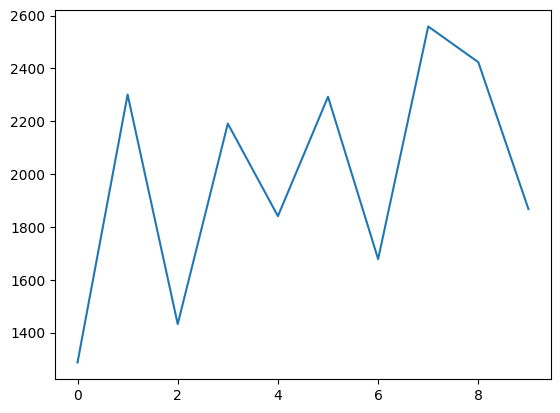

Average validation loss across 10 folds: 44.5804


In [123]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, Normalizer
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.1)  # Add dropout layer with dropout probability of 0.5
        self.fc2 = nn.Linear(64, 64)
        self.dropout2 = nn.Dropout(0.1)  # Add dropout layer with dropout probability of 0.5
        self.fc3 = nn.Linear(64, 32)
        self.dropout3 = nn.Dropout(0.1)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.dropout3(x)
        x = self.fc4(x)
        return x

# Function to train and evaluate the model
def train_and_evaluate_model(X_train, y_train, train_index, val_index):
    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train[train_index], dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values[train_index], dtype=torch.float32).view(-1, 1)  # Reshape y to column vector
    X_val_tensor = torch.tensor(X_train[val_index], dtype=torch.float32)
    y_val_tensor = torch.tensor(y_train.values[val_index], dtype=torch.float32).view(-1, 1)  # Reshape y to column vector

    # Instantiate the model
    input_size = X_train.shape[1]
    model = NeuralNet(input_size)

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Convert data to DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Training the model
    num_epochs = 100
    losses = [] # collecting all the average losses over epochs
    
    for epoch in tqdm(range(num_epochs)):
        total_loss = 0
        total_examples = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss
            total_examples += len(targets)
            loss.backward()
            optimizer.step()
#         # the average loss over all the batches
#         print(f'epoch : {epoch}, loss : {total_loss / total_examples}')
        losses.append(total_loss.detach().numpy() / total_examples)
        
#     plot_pts = [list(np.arange(num_epochs)), losses]
    # plot training losses
#     plot_data(plot_pts[0], plot_pts[1])
    
    # Evaluation
    with torch.no_grad():
        model.eval()
        outputs = model(X_val_tensor)
        val_loss = criterion(outputs, y_val_tensor)
        return val_loss.item()

# Assume your data is X_train and y_train

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
# X_scaled = X_train

# Define 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=False)

val_losses = []
f = 1
# Perform 10-fold cross-validation
for train_index, val_index in kf.split(X_scaled):
    print(f'................... Fold : {f} ...............\n')
    val_loss = train_and_evaluate_model(X_scaled, y_train, train_index, val_index)
    print(f'\nval_loss at fold {f} : {np.sqrt(val_loss)}')
    print(f'-------------------------------------\n')
    val_losses.append(val_loss)
    f += 1

plot_pts = [range(f - 1), val_losses]
plot_data(plot_pts[0], plot_pts[1])
    
# Compute average validation loss
avg_val_loss = np.sqrt(np.mean(val_losses))
print(f'Average validation loss across 10 folds: {avg_val_loss:.4f}')


### Baseline Results

| ID | Model | Degree | Epochs | Regularization | Reg Epochs, Tol, Correlation Threshold, Selection | Lambda | N_features | Folds | RMSE |
| --- | ---- | -------- | ----- | -------------- | ----- | ------ | ----- | ---- | ---- |
| 1 | lr | 1 | None | None | None | 0 | All | 0 | **24.86964904316159** |
| 2 | lr | 1 | None | L2 | X | 20 | X | 10 | 28.506133250715063 |
| 3 | lr | 1 | None | None | None | 0 | 86 | 10 | **29.18143127944806** |
| 4 | lr | 1 | None | L1 | 1000 | 1 | X | 10 | 27.67585141705469 | 
| 5 | lr | 1 | None | L1 | 10000, 0.01 | 1 | X | 10 | 27.666622998342643 |
| 6 | lr | 2 | None | L2 | 2000 | 100 | X | 10 | 44.09927407811474 | 
| 7 | lr | 1 | None | L2 | 2000 | 20 | 68 (Correlation drop off) | 10 | 28.353964603124588 |
| 8 | lr | 1 | None | L1 | 2000 | 1 | 68 | 10 | 27.617890371610304 |
| 9 | lr | 1 | None | L1 | 2000, 0.01, 0.9 | 1 | 68 | 12 | 27.531726534989563 |
| 10 | lr | 1 | None | L1 | 2000, 0.01, 0.89 | 1 | 68 | 12 | 27.531706402729764 |
| 11 | lr | 1 | None | L1 | 2500, 0.03, 0.89, random | 1 | 67 | 12 | **27.369576649451645** |

### Build the Best Model

Select the best model from the grid_search or random_search's best_params and then create the model before prediction

# Prediction

In [ ]:
print(f'X_test.shape : {X_test.shape}')

# predict
# y_test = rr.predict(X_test)
y_test = lasso_regressor.predict(X_test)

test_data_output = pd.DataFrame({'CUST_ID' : test_data['CUST_ID'], 'CREDIT_SCORE' : y_test})

print(f'test_data_output.columns : {test_data_output.columns}')
print(f'test_data_output.shape : {test_data_output.shape}')

### Save Output for Submission

In [ ]:
test_data_output.to_csv(f'{output_path}/submission_id10.csv', index = False)